In [1]:
!pip install -U transformers -q
!pip install -U albumentations -q

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 59 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 46.6 MB/s 
     |████████████████████████████████| 895 kB 71.8 MB/s 
     |████████████████████████████████| 3.3 MB 52.4 MB/s 
     |████████████████████████████████| 102 kB 6.8 MB/s 
     |████████████████████████████████| 47.6 MB 28 kB/s 


In [ ]:
import numpy as np
import torch
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageOps, ImageEnhance
from torchvision import datasets
from tqdm import tqdm
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/MyDrive/datasets/bird_dataset_cropped_yolov5.zip

replace bird_dataset/test_images/mistery_category/ad08ba64f41b7c50feb7701489a25fc9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image=np.array(image))["image"]
        return image, label

from transformers import BeitForImageClassification
nclasses = 20
class BEiTNet(torch.nn.Module):
    def __init__(self):
        super(BEiTNet, self).__init__()
        self.beit =  BeitForImageClassification.from_pretrained('microsoft/beit-large-patch16-224')
        self.beit.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.beit.classifier.in_features,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512,nclasses)
        )

    def forward(self, x):
        return self.beit(x).logits
           
def show_image(dataset, idx=0):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    image, _ = dataset[idx]
    plt.imshow(image)
    plt.set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_dataset_raw = datasets.ImageFolder('bird_dataset' + '/val_images',transform=None)
val_dataset = CustomDataset(val_dataset_raw)
classes = list(val_dataset_raw.class_to_idx.keys())

model = BEiTNet()
checkpoint_pth = './gdrive/MyDrive/models/model_94.17.pth'

if checkpoint_pth is not None:
    checkpoint = torch.load(checkpoint_pth,map_location=device)
    model.load_state_dict(checkpoint)
    del checkpoint

model.to(device)
model.eval();

103
Sample 4, expected: 1,009.Brewer_Blackbird, got: 13,026.Bronzed_Cowbird, confidence: 0.2682042121887207


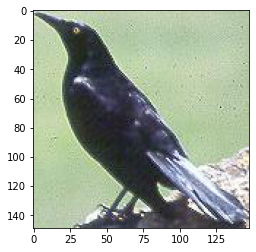

Sample 15, expected: 3,011.Rusty_Blackbird, got: 13,026.Bronzed_Cowbird, confidence: 0.2805684804916382


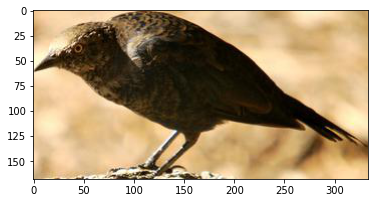

Sample 70, expected: 14,028.Brown_Creeper, got: 11,021.Eastern_Towhee, confidence: 0.34811222553253174


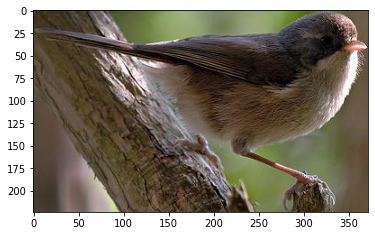

Sample 75, expected: 15,029.American_Crow, got: 16,030.Fish_Crow, confidence: 0.508664608001709


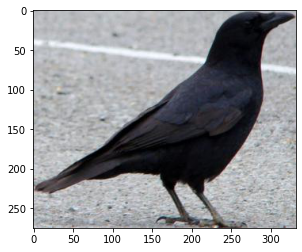

Sample 77, expected: 15,029.American_Crow, got: 16,030.Fish_Crow, confidence: 0.5346993207931519


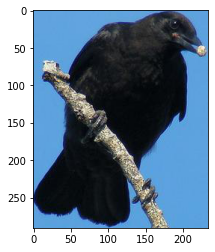

Sample 79, expected: 15,029.American_Crow, got: 16,030.Fish_Crow, confidence: 0.619917094707489


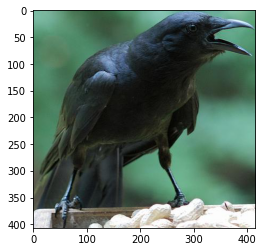

Sample 84, expected: 16,030.Fish_Crow, got: 15,029.American_Crow, confidence: 0.4175570607185364


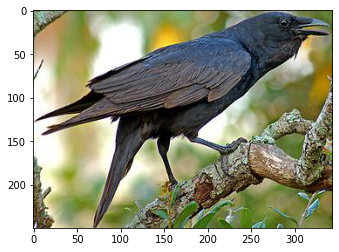

In [ ]:
softmax = torch.nn.Softmax(dim=1)
print(len(val_dataset))
with torch.no_grad():
    for i, (data,target) in enumerate(val_dataset):
        data = data.to(device).unsqueeze(0)
        output = softmax(model(data)).squeeze()
        pred = torch.argmax(output)
        if pred != target:
            print(f'Sample {i}, expected: {target},{classes[target]}, got: {pred},{classes[pred]}, confidence: {torch.max(output)}')
            image = val_dataset_raw[i][0]
            plt.imshow(image)
            plt.show()